# Drinks Consumption Modeling

This notebook builds and evaluates classification models (Random Forest & SVM) to predict **high** vs. **low** alcohol consumption using the `drinks.csv` dataset.

**Outline**  
1. Imports & Data Loading  
2. Exploratory Data Analysis 
3. Preprocessing Pipeline  
4. Baseline Models  
5. Hyperparameter Tuning  
6. Final Evaluation  
7. Conclusions  

In [ ]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# 2. Load the dataset
df = pd.read_csv('drinks.csv')

le = LabelEncoder()
df['country_code'] = le.fit_transform(df['country'])
df = df.drop(columns=['country'])
df['alcohol_level'] = (df['total_litres_of_pure_alcohol'].apply(lambda x: 'high' if x > 10 else 'low'))

df.head(), df.info(), df['alcohol_level'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   beer_servings                 193 non-null    int64  
 1   spirit_servings               193 non-null    int64  
 2   wine_servings                 193 non-null    int64  
 3   total_litres_of_pure_alcohol  193 non-null    float64
 4   country_code                  193 non-null    int64  
 5   alcohol_level                 193 non-null    object 
dtypes: float64(1), int64(4), object(1)
memory usage: 9.2+ KB


(   beer_servings  spirit_servings  wine_servings  \
 0              0                0              0   
 1             89              132             54   
 2             25                0             14   
 3            245              138            312   
 4            217               57             45   
 
    total_litres_of_pure_alcohol  country_code alcohol_level  
 0                           0.0             0           low  
 1                           4.9             1           low  
 2                           0.7             2           low  
 3                          12.4             3          high  
 4                           5.9             4           low  ,
 None,
 alcohol_level
 low     168
 high     25
 Name: count, dtype: int64)

beer_servings                   0
spirit_servings                 0
wine_servings                   0
total_litres_of_pure_alcohol    0
country_code                    0
alcohol_level                   0
dtype: int64
       beer_servings  spirit_servings  wine_servings  \
count     193.000000       193.000000     193.000000   
mean      106.160622        80.994819      49.450777   
std       101.143103        88.284312      79.697598   
min         0.000000         0.000000       0.000000   
25%        20.000000         4.000000       1.000000   
50%        76.000000        56.000000       8.000000   
75%       188.000000       128.000000      59.000000   
max       376.000000       438.000000     370.000000   

       total_litres_of_pure_alcohol  country_code  
count                    193.000000    193.000000  
mean                       4.717098     96.000000  
std                        3.773298     55.858452  
min                        0.000000      0.000000  
25%               

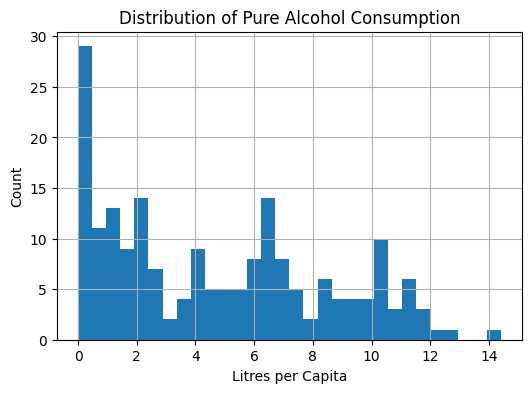

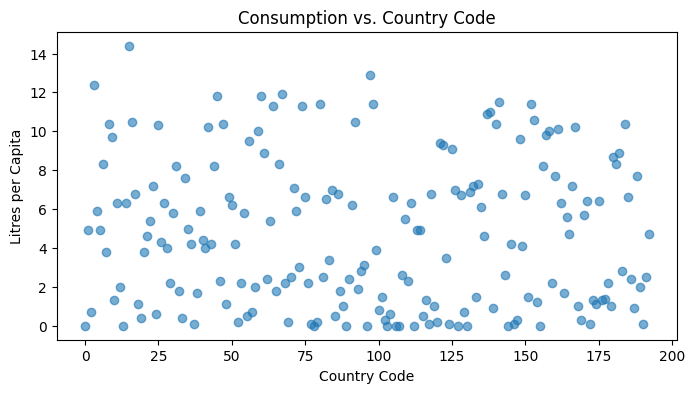

In [ ]:
# 3. Exploratory Data Analysis (EDA)
print(df.isnull().sum())
print(df.describe())
print(df['alcohol_level'].value_counts())

# 3.3 Histogram 
plt.figure(figsize=(6,4))
df['total_litres_of_pure_alcohol'].hist(bins=30)
plt.title('Distribution of Pure Alcohol Consumption')
plt.xlabel('Litres per Capita')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(df['country_code'], df['total_litres_of_pure_alcohol'], alpha=0.6)
plt.title('Consumption vs. Country Code')
plt.xlabel('Country Code')
plt.ylabel('Litres per Capita')
plt.show()

In [ ]:
# 4. Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = [
    'beer_servings',
    'wine_servings',
    'spirit_servings',
    'total_litres_of_pure_alcohol',
    'country_code'
]

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler())
])

preprocessor = ColumnTransformer([
    ('nums', num_pipe, num_cols)
], remainder='drop')

X = df[num_cols]
y = df['alcohol_level']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 5. Baseline Models

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm      import SVC

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])
rf_pipe.fit(X_train, y_train)

# SVM pipeline
svm_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', SVC(probability=True, random_state=42))
])
svm_pipe.fit(X_train, y_train)

from sklearn.metrics import classification_report

print("=== RF Baseline ===")
print(classification_report(y_test, rf_pipe.predict(X_test)))
print("=== SVM Baseline ===")
print(classification_report(y_test, svm_pipe.predict(X_test)))

=== RF Baseline ===
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         5
         low       1.00      1.00      1.00        34

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

=== SVM Baseline ===
              precision    recall  f1-score   support

        high       0.83      1.00      0.91         5
         low       1.00      0.97      0.99        34

    accuracy                           0.97        39
   macro avg       0.92      0.99      0.95        39
weighted avg       0.98      0.97      0.98        39



In [30]:
# 6. Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

rf_params = {
    'clf__n_estimators': [100, 300, 500],
    'clf__max_depth':    [None, 10, 20]
}
svm_params = {
    'clf__C':     [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

gs_rf  = GridSearchCV(rf_pipe,  rf_params, cv=5, scoring='f1_macro')
gs_svm = GridSearchCV(svm_pipe, svm_params, cv=5, scoring='f1_macro')

gs_rf.fit(X_train, y_train)
gs_svm.fit(X_train, y_train)

print("Best RF params:", gs_rf.best_params_)
print("Best SVM params:", gs_svm.best_params_)

Best RF params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Best SVM params: {'clf__C': 1, 'clf__kernel': 'linear'}


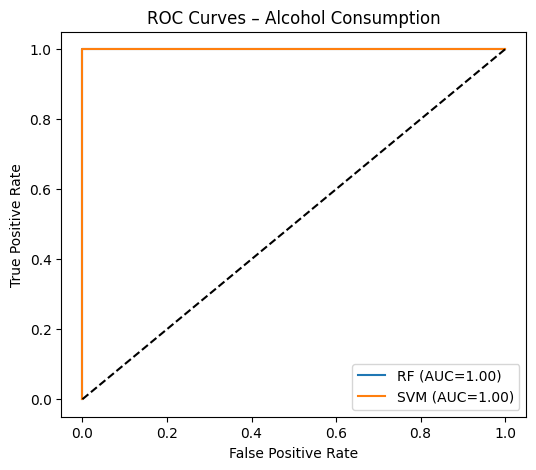

=== RF Classification Report ===
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         5
         low       1.00      1.00      1.00        34

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

RF Confusion Matrix:
[[34  0]
 [ 0  5]]

=== SVM Classification Report ===
              precision    recall  f1-score   support

        high       0.83      1.00      0.91         5
         low       1.00      0.97      0.99        34

    accuracy                           0.97        39
   macro avg       0.92      0.99      0.95        39
weighted avg       0.98      0.97      0.98        39

SVM Confusion Matrix:
[[33  1]
 [ 0  5]]

SVM 5-fold F1 macro: [0.88529412 1.         0.93719807 0.94685315 0.93698176] 0.9412654180020672


In [ ]:
# 7. Final Evaluation: ROC, AUC & Confusion Matrices

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score


y_true_bin = y_test.map({'low': 0, 'high': 1})

rf_best  = gs_rf.best_estimator_
svm_best = gs_svm.best_estimator_

rf_pos_idx  = list(rf_best.named_steps['clf'].classes_).index('high')
svm_pos_idx = list(svm_best.named_steps['clf'].classes_).index('high')

# Extract correct probabilities for ROC
y_prob_rf  = rf_best.predict_proba(X_test)[:, rf_pos_idx]
y_prob_svm = svm_best.predict_proba(X_test)[:, svm_pos_idx]

plt.figure(figsize=(6,5))
for name, probs in [('RF', y_prob_rf), ('SVM', y_prob_svm)]:
    fpr, tpr, _ = roc_curve(y_true_bin, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr, tpr):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves – Alcohol Consumption')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.show()

# Confusion matrices and classification reports
for name, model in [('RF', rf_best), ('SVM', svm_best)]:
    y_pred = model.predict(X_test)
    # Convert to Series and map to binary
    y_pred_bin = pd.Series(y_pred).map({'low': 0, 'high': 1})
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    print(f"{name} Confusion Matrix:\n{cm}\n")
svm_scores = cross_val_score(svm_pipe, X, y, cv=5, scoring='f1_macro')
print("SVM 5-fold F1 macro:", svm_scores, svm_scores.mean())

## Conclusions

- **Dataset & Task**  
  We classified countries into **high** (>10 L/person) vs. **low** (≤10 L) alcohol consumption.

- **Model Performance**  
  - **Random Forest:**  
    - Test F1-macro = 1.000  
    - 5-fold CV F1-macro = [1.00, 1.00, 1.00, 1.00, 0.937] → **0.987 avg**  
  - **SVM:**  
    - Test F1-macro = 0.947  
    - 5-fold CV F1-macro = [0.885, 1.00, 0.937, 0.947, 0.937] → **0.941 avg**

- **Key Insights**  
  - RF is extremely stable and achieved perfect test performance.  
  - SVM also performed very well but showed slightly higher variance across folds.

- **Caveats**  
  - Only 39 test samples (5 “high”) → small-sample fluctuations matter.  
  - Country coding imposes an arbitrary numeric ordering—consider one-hot if ordering effects arise.